<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/class_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of DoE
In this jupyter book, we use the data from the video and perform the analysis with our python tools.

We startwith importing the needed modules, followed by loading the data.

In [121]:
import pandas as pd
import numpy as np

data=pd.read_excel('data_example.xlsx', index_col=0, header=1)
data

,Time,Temp,Pressure,Unnamed: 4,Unnamed: 5,Y1,Y2,Y3,Y4,Y5,Unnamed: 11,Average,Sigma
Row#,,,,,,,,,,,,,
1,5,0,0.2,NaN,NaN,77.55,81.34,79.96,75.55,78.84,NaN,78.648,2.225325
2,5,0,1.0,NaN,NaN,164.35,157.98,153.99,154.09,152.63,NaN,156.608,4.765493
3,5,90,0.2,NaN,NaN,71.28,73.70,75.41,69.49,71.12,NaN,72.200,2.340459
4,5,90,1.0,NaN,NaN,157.88,158.08,155.40,156.74,154.04,NaN,156.428,1.709830
5,100,0,0.2,NaN,NaN,-0.05,-0.64,5.41,5.27,-2.96,NaN,1.406,3.752683
6,100,0,1.0,NaN,NaN,84.64,84.20,76.99,84.51,83.33,NaN,82.734,3.251343
7,100,90,0.2,NaN,NaN,2.23,-5.02,-1.05,-5.53,2.86,NaN,-1.302,3.923018
8,100,90,1.0,NaN,NaN,87.26,86.24,89.74,82.02,81.28,NaN,85.308,3.583200


Since the excel file we loaded the data from included empty rows, we need to clean it. this can be done using the drop function in pandas.

In [122]:
data=data.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 11'], axis=1)
data

,Time,Temp,Pressure,Y1,Y2,Y3,Y4,Y5,Average,Sigma
Row#,,,,,,,,,,
1,5,0,0.2,77.55,81.34,79.96,75.55,78.84,78.648,2.225325
2,5,0,1.0,164.35,157.98,153.99,154.09,152.63,156.608,4.765493
3,5,90,0.2,71.28,73.70,75.41,69.49,71.12,72.200,2.340459
4,5,90,1.0,157.88,158.08,155.40,156.74,154.04,156.428,1.709830
5,100,0,0.2,-0.05,-0.64,5.41,5.27,-2.96,1.406,3.752683
6,100,0,1.0,84.64,84.20,76.99,84.51,83.33,82.734,3.251343
7,100,90,0.2,2.23,-5.02,-1.05,-5.53,2.86,-1.302,3.923018
8,100,90,1.0,87.26,86.24,89.74,82.02,81.28,85.308,3.583200


In the video, the DoE was alreay performed, so he already had the design matrix. Let's do it, it makes it prettier and easier to follow.First, let's find the span and label of each variable:

In [125]:
# create dictionary for parameters
inputs_labels = {'A' : data.columns[0],
                 'B' :  data.columns[1],
                 'C' :  data.columns[2]}

#create list of data for high and low.
dat = [ ('A',data.loc[:,'Time'].min(),data.loc[:,'Time'].max()),
        ('B',data.loc[:,'Temp'].min(),data.loc[:,'Temp'].max()),
        ('C',data.loc[:,'Pressure'].min(),data.loc[:,'Pressure'].max())]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,high,label
index,,,
A,5.0,100.0,Time
B,0.0,90.0,Temp
C,0.2,1.0,Pressure


and encode the data usng the span and the averages:

In [126]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
A,5.0,100.0,Time,-1.0,1.0
B,0.0,90.0,Temp,-1.0,1.0
C,0.2,1.0,Pressure,-1.0,1.0


and generate the design matrix:

In [127]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1],[-1,1]))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [128]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B','C']
results

,A,B,C
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1


which gives the following matrix for the experiments to be performed:

In [129]:
real_experiment = results

var_labels = []
for var in ['A','B','C']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else inputs_df.loc[var]['high'] ,
        axis=1)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Time,Temp,Pressure
0,5.0,0.0,0.2
1,100.0,0.0,0.2
2,5.0,90.0,0.2
3,100.0,90.0,0.2
4,5.0,0.0,1.0
5,100.0,0.0,1.0
6,5.0,90.0,1.0
7,100.0,90.0,1.0


Note that the order is changed from the minitab example. However, this will not the results. The choice is upt to you, I prefer to divide it like this :).

## 2. Look us also have closer look at response

In the data table, the average y and standard deviation is already given... however, if they are not we can easily compute them using pandas and numpy.

In [130]:
y=data.loc[:,'Y1':'Y5']
# We already had the average y and standard deviation in the table, if not, these are easily accessible pandas and numpy.
y_mean=y.mean(axis=1)
y_std = y.std(axis=1)
results['y']=y_mean.to_list()
results['s']=y_std.to_list()
results

,A,B,C,Time,Temp,Pressure,y,s
0,-1,-1,-1,5.0,0.0,0.2,78.648,2.225325
1,1,-1,-1,100.0,0.0,0.2,156.608,4.765493
2,-1,1,-1,5.0,90.0,0.2,72.200,2.340459
3,1,1,-1,100.0,90.0,0.2,156.428,1.709830
4,-1,-1,1,5.0,0.0,1.0,1.406,3.752683
5,1,-1,1,100.0,0.0,1.0,82.734,3.251343
6,-1,1,1,5.0,90.0,1.0,-1.302,3.923018
7,1,1,1,100.0,90.0,1.0,85.308,3.583200


These values will of course be the same as the one in the original data table

In [131]:
data[['Average','Sigma']]

,Average,Sigma
Row#,,
1,78.648,2.225325
2,156.608,4.765493
3,72.200,2.340459
4,156.428,1.709830
5,1.406,3.752683
6,82.734,3.251343
7,-1.302,3.923018
8,85.308,3.583200


## 3. Let's analyse the results
In this example we will use statmodels and its "fit to formula function" to analyze the results. Since we are looking at the column for the average the full model since then we will not have any degrees of freedom to make a statistical analysis of our model. It is still possibble to perform the OLS with the full model; you just won't get any statistics for your model (test this yourself).

How to reduce the model?
Here, we often use domain expertise... and expercience. In physics and chemistry, a general rule of thumb is that higher order intercations can be neglected. In this first shot, we therefore remove the **ABC** interaction.

We start looking at the standard variation:

In [132]:
import statsmodels.formula.api as smf


dat=results.loc[:,'A':'C']
dat['s']=results.loc[:,'s']

mod = smf.ols(formula='s ~ A + B + C + A:B + A:C + B:C', data=dat)

res = mod.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      s   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                 -0.324
Method:                 Least Squares   F-statistic:                    0.7144
Date:                Tue, 24 Sep 2024   Prob (F-statistic):              0.718
Time:                        12:20:58   Log-Likelihood:                -4.3453
No. Observations:                   8   AIC:                             22.69
Df Residuals:                       1   BIC:                             23.25
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1939      0.417      7.668      0.083      -2.099       8.487
A              0.1335      0.417      0.321      0.802      -5.159       5.426
B             -0.3048      0.417     -0.732      0.598      -5.597       4.988
C              0.4336      0.417      1.041      0.487      -4.859       5.726
A:B           -0.3762      0.417     -0.903      0.532      -5.669       4.916
A:C           -0.3438      0.417     -0.825      0.561      -5.636       4.949
B:C            0.4303      0.417      1.033      0.490      -4.862       5.723
==============================================================================
Omnibus:                        8.655   Durbin-Watson:                   2.500
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                1.333
Skew:                           0.000   Prob(JB):                        0.513
Kurtosis:                       1.000   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we see, none of the terms are significant (high p-values) indicating that the model is not of any use for us.


Lets turn to the response (y):

In [133]:
import statsmodels.formula.api as smf


dat=results.loc[:,'A':'C']
dat['y']=results.loc[:,'y']

mod = smf.ols(formula='y ~ A + B + C + A:B + A:C + B:C', data=dat)

res = mod.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.372e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):            0.00417
Time:                        12:21:04   Log-Likelihood:                 5.3968
No. Observations:                   8   AIC:                             3.206
Df Residuals:                       1   BIC:                             3.762
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.0037      0.123    641.004      0.001      77.438      80.570
A             41.2658      0.123    334.813      0.002      39.700      42.832
B             -0.8453      0.123     -6.858      0.092      -2.411       0.721
C            -36.9672      0.123   -299.937      0.002     -38.533     -35.401
A:B            1.4437      0.123     11.714      0.054      -0.122       3.010
A:C            0.7188      0.123      5.832      0.108      -0.847       2.285
B:C            0.8118      0.123      6.586      0.096      -0.754       2.378
==============================================================================
Omnibus:                        8.655   Durbin-Watson:                   2.500
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                1.333
Skew:                          -0.000   Prob(JB):                        0.513
Kurtosis:                       1.000   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: test to add the **ABC** interaction. When we use the full model, we do not have any Degrees of freedom to evaluate residuals, i.e. **Df Residuals:	0**. But we can still use this data to analyze the standardized effects of our variables and interactions between variables. Don't forget to reduce the model before you continue with the following boxes.




In the model for y we have A and B that show p-values smaller than 0.05, which means that they significantly contribute to the model. The rest are larger and are thus not significant.

This can also bee analyzed in a graphical form. To do this, we summarize the data and plot the results in a **Pareto chart**. This is done by computing the standardized effects and the cumulative percentage of standardized effects, i.e. the percentage of how much of the total effect each individual effect contributes with.  

In [134]:
effects=pd.DataFrame()

# the standardised effects are the absolute values of the coefficients obtained from the OLS.
effects['Standardized effect']=pd.DataFrame(np.abs(res.params[1:]))

# Add cumulative percentage column.
effects["cum_percentage"] = round(effects["Standardized effect"].cumsum()/effects["Standardized effect"].sum()*100,2)
effects

,Standardized effect,cum_percentage
A,41.26575,50.29
B,0.84525,51.32
C,36.96725,96.38
A:B,1.44375,98.13
A:C,0.71875,99.01
B:C,0.81175,100.00


This is best illustrated using a results in a Pareto chart.

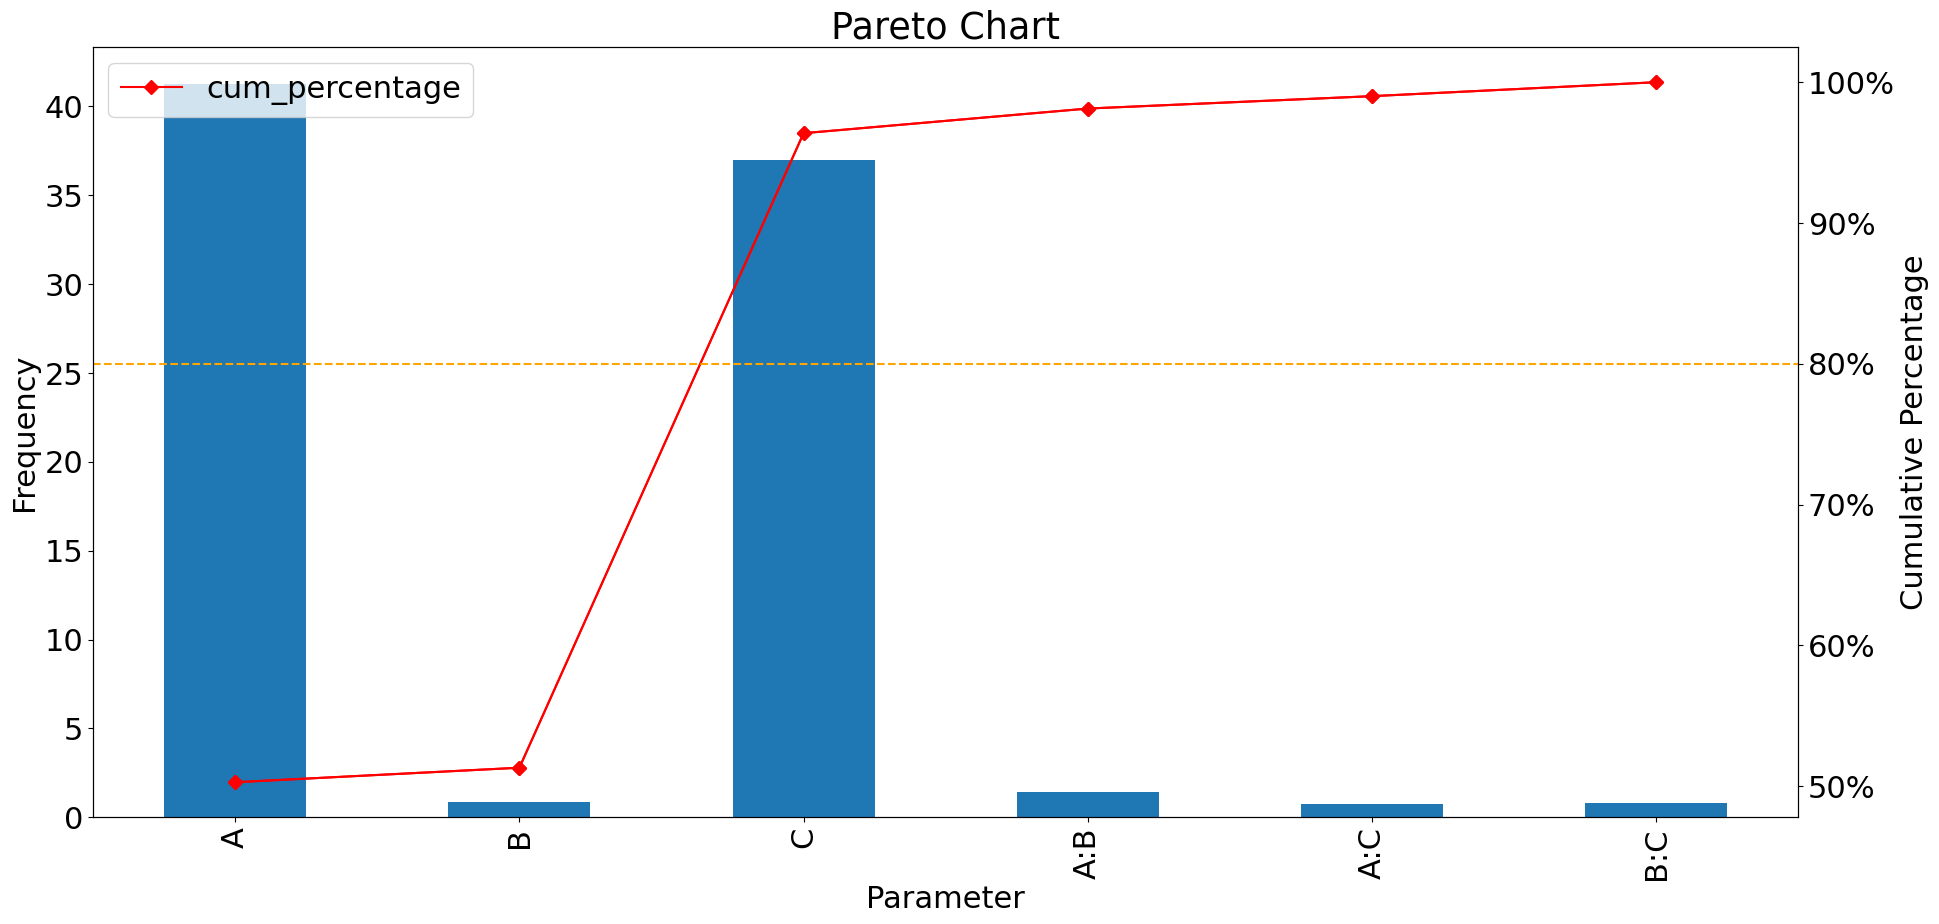

In [135]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({'font.size': 22})
# Set figure and axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
ax.set_title("Pareto Chart")
ax.set_xlabel("Parameter")
ax.set_ylabel("Frequency");
effects['Standardized effect'].plot.bar(ax=ax)

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(effects.index, effects["cum_percentage"], color="red", marker="D", ms=7)
effects.plot(y="cum_percentage", color="red", marker="D", ms=7, ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");
ax2.axhline(80, color="orange", linestyle="dashed")


The orange line is the Pareto Principle of *"Vital few"* and *"Trivial many"*, also called the 80/20 tule. The “vital few” are contributing to 80% of the problem, therefore, they should take the highest priority when determining areas to improve as they will give you the “biggest bang for your buck”. Since the “trivial many” only represent 20% of the problem, you will not see much improvement if you focus on these areas. This is the idea behind the 80/20 rule which we will dive deeper into below.

To better illustrate the results, it might be wise to sort the data. This can be done with the **sort_values** function in pandas.



In [136]:
effects_sorted = effects.sort_values(by='Standardized effect', ascending=False)
effects_sorted

,Standardized effect,cum_percentage
A,41.26575,50.29
C,36.96725,96.38
A:B,1.44375,98.13
B,0.84525,51.32
B:C,0.81175,100.00
A:C,0.71875,99.01


and be visualized in a Pareto chart

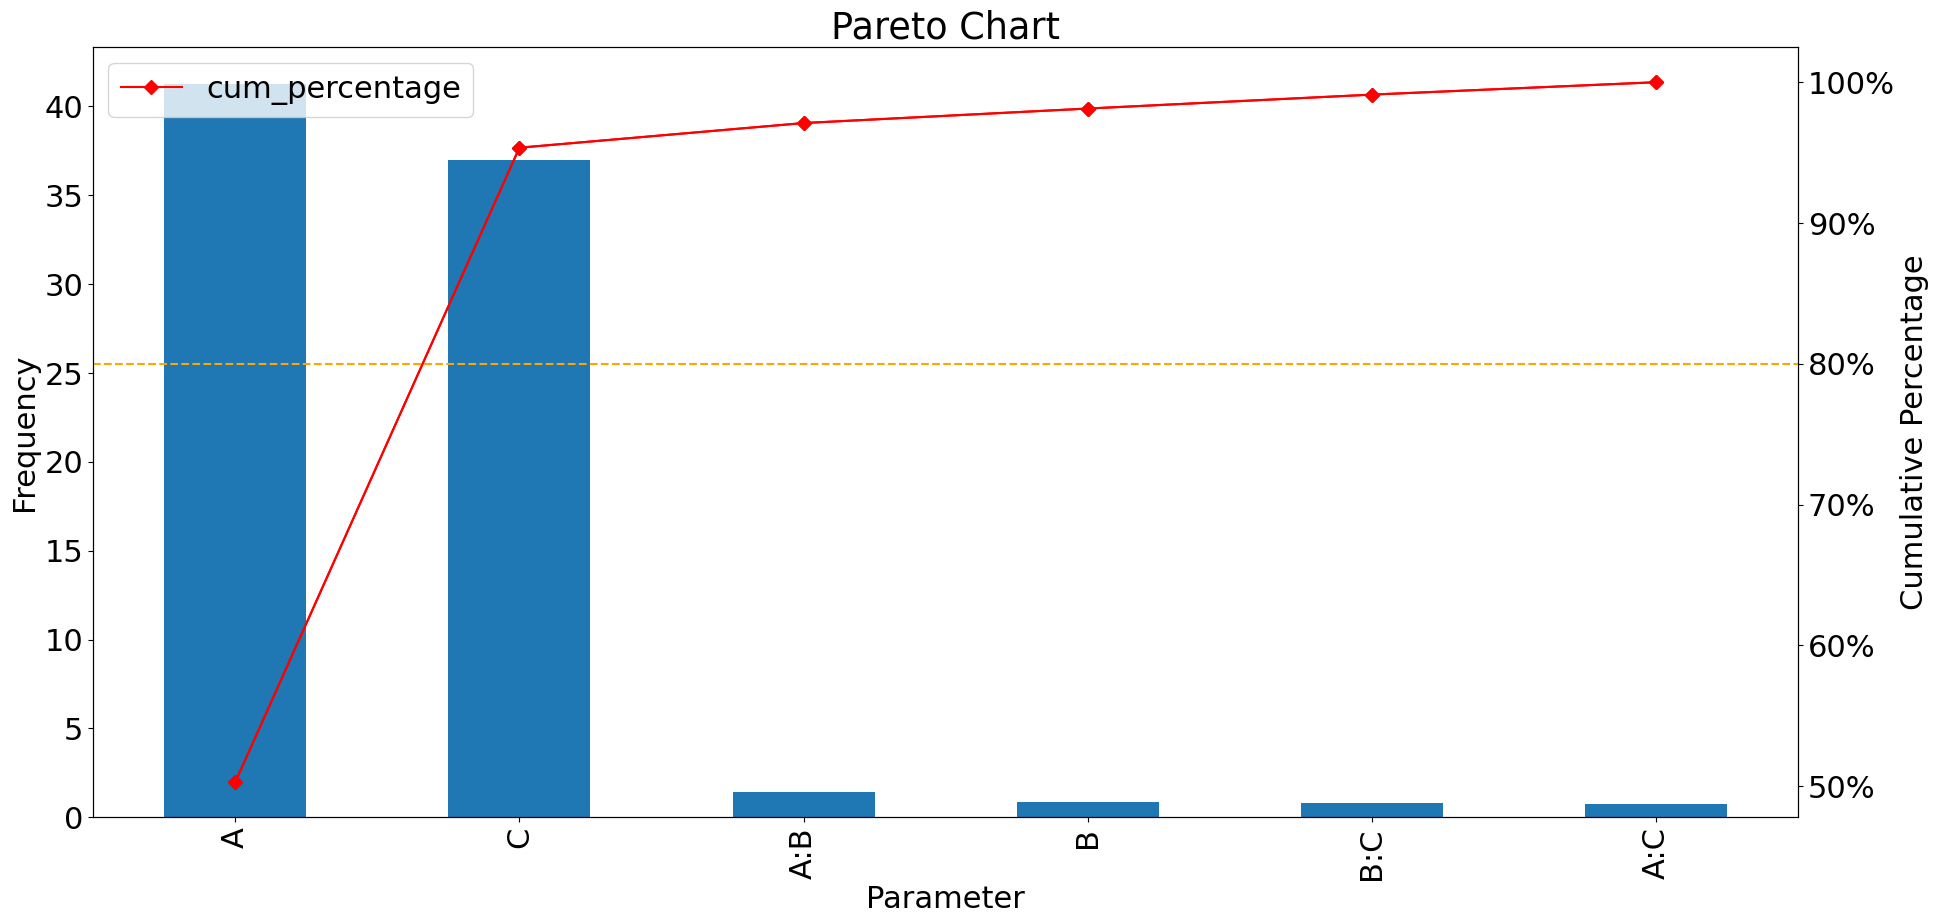

In [137]:
# Add cumulative percentage column.
effects_sorted["cum_percentage"] = round(effects_sorted["Standardized effect"].cumsum()/effects_sorted["Standardized effect"].sum()*100,2)

# and plot Pareto Chart
plt.rcParams.update({'font.size': 22})
# Set figure and axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
ax.set_title("Pareto Chart")
ax.set_xlabel("Parameter")
ax.set_ylabel("Frequency");
effects_sorted['Standardized effect'].plot.bar(ax=ax)

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(effects_sorted.index, effects_sorted["cum_percentage"], color="red", marker="D", ms=7)
effects_sorted.plot(y="cum_percentage", color="red", marker="D", ms=7, ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");
ax2.axhline(80, color="orange", linestyle="dashed")


Here we clearly se that A and C are the important parameters in our model. Let's use them and create the final model.

In [139]:
mod = smf.ols(formula='y ~ A + C', data=dat)

res = mod.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1923.
Date:                Tue, 24 Sep 2024   Prob (F-statistic):           6.07e-08
Time:                        12:22:10   Log-Likelihood:                -16.886
No. Observations:                   8   AIC:                             39.77
Df Residuals:                       5   BIC:                             40.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.0037      0.893     88.444      0.000      76.708      81.300
A             41.2657      0.893     46.197      0.000      38.970      43.562
C            -36.9672      0.893    -41.385      0.000     -39.263     -34.671
==============================================================================
Omnibus:                        1.488   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                0.724
Skew:                           0.691   Prob(JB):                        0.696
Kurtosis:                       2.486   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we have a model, and we can ask it to give test the model... Let's start with the real data...

In [141]:
ypred = res.predict(results.loc[:,'A':'C'])
print(ypred)

0     74.70525
1    157.23675
2     74.70525
3    157.23675
4      0.77075
5     83.30225
6      0.77075
7     83.30225
dtype: float64


and then add more data points:

In [163]:
#A_t=np.linspace(inputs_df['high']['A']-inputs_df['low']['A'], 10)
#B_t=np.linspace(inputs_df['high']['A']-inputs_df['low']['B'], 10)
#C_t=np.linspace(inputs_df['high']['A']-inputs_df['low']['C'], 10)

A_t=np.linspace(-1, 1, 10)
B_t=np.linspace(-1, 1, 10)
C_t=np.linspace(-1, 1, 10)

df_t=pd.DataFrame({'A':A_t,'B':B_t,'C':C_t })

# before we can predict anythin, we need to transform the values to

In [165]:
df_t

,A,B,C
0,-1.000000,-1.000000,-1.000000
1,-0.777778,-0.777778,-0.777778
2,-0.555556,-0.555556,-0.555556
3,-0.333333,-0.333333,-0.333333
4,-0.111111,-0.111111,-0.111111
5,0.111111,0.111111,0.111111
6,0.333333,0.333333,0.333333
7,0.555556,0.555556,0.555556
8,0.777778,0.777778,0.777778
9,1.000000,1.000000,1.000000


In [166]:
ypred_T = res.predict(df_t.loc[:,'A':'C'])
print(ypred_T)

0    74.705250
1    75.660472
2    76.615694
3    77.570917
4    78.526139
5    79.481361
6    80.436583
7    81.391806
8    82.347028
9    83.302250
dtype: float64


In [164]:
# Analyze the response surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['LearningRate'], df['BatchSize'], df['Accuracy'], c='r', marker='o')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Accuracy')
plt.show()

In [ ]:
# Optimization (Gradient Descent - Simplified)
from scipy.optimize import minimize

def objective(params):
    lr, bs, hl = params
    return -model.predict(pd.DataFrame({'LearningRate': [lr], 'BatchSize': [bs], 'HiddenLayers': [hl]}))[0]

initial_guess = [0.01, 32, 2]
result = minimize(objective, initial_guess, bounds=[(0.001, 0.1), (16, 64), (1, 3)], method='L-BFGS-B')
optimal_params = result.x

print(f'Optimal Learning Rate: {optimal_params[0]}')
print(f'Optimal Batch Size: {optimal_params[1]}')
print(f'Optimal Hidden Layers: {optimal_params[2]}')